$\textbf{Predicting Street Speed with Weather Data}$
1. In this notebook I test out some missing value methods for the Uber Map Reduce
time series output.

2. Then I import the weather data for March 2019 and plot some of its features to determine 
what to use.

3. In order to test a weather series "causes" (has a statistically significant impact on predicting) the speed of a certain segment we apply Granger Causality but first we need to test if a series is stationary and if not
then we need to transform it into a stationary time series.


In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [29]:
file = open("uber_mr.txt","r")  #hourly street speed data for each segment, 744 values (some null for some streets)
lines = file.readlines()
file.close()

In [3]:
#This method calculates and fills missing values for a segment
#Input: double time series with nulls set to 0
def fill_missing(ar):   #we fill in missing values (initially set 0) 
    locs = np.where(ar != 0)[0]
    #we get the average speed of the nonzero values for each hour
    average_hourly = np.zeros(24)
    for i in range(len(average_hourly)):
        speed_indexs = np.where(locs%24==i)[0]
        if len(speed_indexs) == 0:
            average_hourly[i] = 0
        else:
            average_hourly[i] = np.mean(ar[speed_indexs])
#if an hours average value is 0 we try to set to h-1, if also zero to h+1 otherwise we set
# fill values = False and take the average monthly speed
    fill_values = True
    for i in range(len(average_hourly)):
        if average_hourly[i] == 0:
            if average_hourly[(i-1)%24] != 0:
                average_hourly[i] = average_hourly[(i-1)%24]
            else:
                if average_hourly[(i+1)%24] != 0:
                    average_hourly[i] = average_hourly[(i+1)%24]
                else:
                    fill_values = False
    if fill_values == False :
        monthly_average = np.mean(ar[locs])
        ar.fill(monthly_average)
    else:
        zero_locs = np.where(ar==0)[0]
        for j in range(len(zero_locs)):
            ar[zero_locs[j]] = average_hourly[zero_locs[j]%24]

In [30]:
#We get the street speeds for each segment, filling missing values
#If too many missing values we set time series = avg mph
speeds = []
speeds_smoothed = []   #rolling average we may utilize
for i in range(len(lines)): #  we format the data 
    street, time_series_str = lines[i].strip().split("\t")
    ar = np.array(time_series_str.split(","))
    ar = np.array(np.where(ar=="null",str("0"),ar)).astype(np.double)
    fill_missing(ar)
    df = pd.DataFrame(ar,columns = ["speed"])
    df['SMA_10'] = df.speed.rolling(2, min_periods=1).mean()          #get the rolling average to smooth everything out
    speeds.append(df["speed"])
    speeds_smoothed.append(df["SMA_10"])

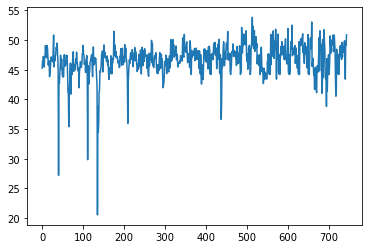

In [31]:
plt.plot(speeds[3])  #show large variability (outliers) during early part of march, we may want to smooth

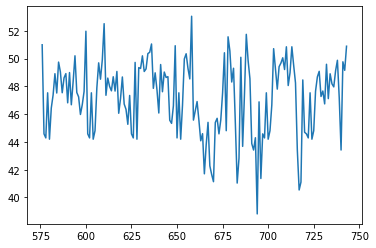

In [35]:
plt.plot(speeds[3][-168:])  #we can see somewhat of a trend through the week and definite daily trends

In [37]:
file = open("weather-2020-03.txt","r")  
weather_lines = file.readlines()
file.close()

$\textbf{Weather Feature Description}$

0. HourlyDryBulbTemperature ( in Fahrenheit, the dry bulb is the commonly used temperature measuring method for reporting)
1. HourlyPrecipitation (inches)
2. HourlyPresentWeatherType (weather observation, coded as RA:16 for rain, SN:18 for snow, etc; I'm trying to decode the ones that are important to our project)
3. HourlySkyConditions (eg: CLR-00, I'm thinking this feature is not as important and we may drop it)
4. HourlyVisibility (horizontal distance, in miles)
5. HourlyWindGustSpeed (mph, if any gusts occurring during the time of observation).
6. HourlyWindSpeed (mph)

In [40]:
days = []
hours = []
temps = []
precipitations = []
weather_types = []
sky_conditions = []
visibilities = []
wind_gust_speeds = []
wind_speeds = []

In [41]:
#Formatting of weather data ingestion
for i in range(len(weather_lines)):
    ar = weather_lines[i].strip().split(",")
    day = ar[0]
    hour = ar[1].split('\t')[0]
    if hour == '24':
        continue
    hours.append(hour)
    days.append(day)
    temp = ar[1].split('\t')[1]
    temps.append(temp)
    precipitation = ar[2]
    precipitations.append(precipitation)
    weather_type = ar[3]
    weather_types.append(weather_type)
    sky_condition = ar[4]
    sky_conditions.append(sky_condition)
    visibility = ar[5]
    visibilities.append(visibility)
    wind_gust_speed = ar[6]
    wind_gust_speeds.append(wind_gust_speed)
    wind_speed = ar[7]
    wind_speeds.append(wind_speed)

In [42]:
days = np.array(days)
hours = np.array(hours)
temps = np.array(temps)
precipitations = np.array(precipitations)
weather_types = np.array(weather_types)
sky_conditions = np.array(sky_conditions)
visibilities = np.array(visibilities)
wind_gust_speeds = np.array(wind_gust_speeds)
wind_speeds = np.array(wind_speeds)

In [43]:
df = pd.DataFrame(data = [days,hours,temps,precipitations,weather_types,sky_conditions,visibilities,wind_gust_speeds,wind_speeds]).T

In [44]:
df.columns = ["day","hour","temp","precipitation","weather_type","sky_condition","visibility","wind_gust_speed","wind_speed"]

$\textbf{Time Series Analysis}$

1. I focused on a specific time series (temp) which had the most potential, but I 
will look into others (precipitation, visiblity, wind) and run tests on all of them
and potentially try to combine them

2. I plotted temp and visibility to indicate their features

3. After filling missing values for temp (will be done more rigorously) I calculated 
the ADF statistic and corresponding p-value for temp and street speed being stationary.
If p-value <0.05 it is stationary, otherwise we take the 1st order difference and calculate
again. 

4. After getting stationary time series for temp and speed I applied granger causality for 
(temp,speed). This tests if using lag = [1,2...7] for temp is useful in predicting speed. 
In other words, if we know the temp for last 7 hours will that information be useful in 
predicting speed for our specific segment. 

In [171]:
temp_strs = df["temp"].values
temp_strs = np.where(temp_strs == "", "0", temp_strs)
temp_time_series = temp_strs.astype(np.double)
avg_temp = np.mean(temp_time_series)
temp_time_series = np.where(temp_time_series==0,avg_temp,temp_time_series)
visibility_time_series = df["visibility"].values.astype(np.double)
speed_time_series = speeds[10]  #Lets use a road with many data points ---Feel free to change and play around

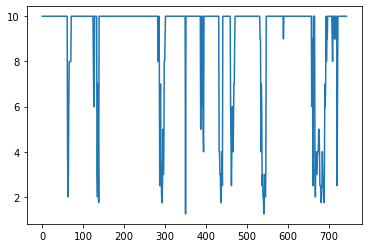

In [172]:
plt.plot(visibility_time_series)

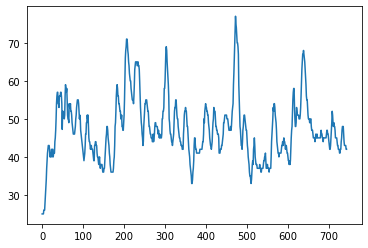

In [173]:
plt.plot(temp_time_series)

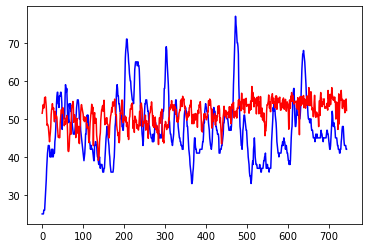

In [174]:
plt.plot(temp_time_series,"b")
plt.plot(speed_time_series,"r")

In [175]:
from statsmodels.tsa.stattools import adfuller, kpss

In [176]:
def difference(dataset, interval =1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [177]:
#Performs test for stationary property, takes difference if needed
def test_stationary(time_series):
    result = adfuller(time_series,autolag="AIC")
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] >= 0.05:
        time_series_stat = difference(time_series)
        print("Non Stationary: Taking Difference\n")
        result = adfuller(time_series_stat,autolag="AIC")
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        return time_series_stat
    else:
        print("Stationary\n")
        return time_series

In [178]:
stationary_speed = test_stationary(speed_time_series)

ADF Statistic: -1.994416583125845
p-value: 0.28902658635945533
Non Stationary: Taking Difference

ADF Statistic: -13.843301029449762
p-value: 7.225776658574602e-26


In [179]:
stationary_temp = test_stationary(temp_time_series)

ADF Statistic: -3.366242056584554
p-value: 0.012164940709487027
Stationary



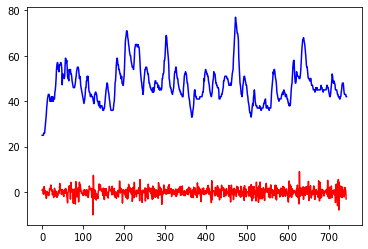

In [180]:
plt.plot(stationary_temp,'b')
plt.plot(stationary_speed,'r')

In [181]:
from statsmodels.tsa.stattools import grangercausalitytests



In [182]:
n = min(len(stationary_temp),len(stationary_speed))
d = pd.DataFrame(data=[stationary_temp[:n],stationary_speed[:n]]).T

In [183]:
grangercausalitytests(d,maxlag=7)
#Results below indicate that for this specific street segment when using a lag of 
#4 or more the temperature IS a useful predictor for street speed.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5691  , p=0.4509  , df_denom=739, df_num=1
ssr based chi2 test:   chi2=0.5714  , p=0.4497  , df=1
likelihood ratio test: chi2=0.5712  , p=0.4498  , df=1
parameter F test:         F=0.5691  , p=0.4509  , df_denom=739, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7127  , p=0.1811  , df_denom=736, df_num=2
ssr based chi2 test:   chi2=3.4486  , p=0.1783  , df=2
likelihood ratio test: chi2=3.4406  , p=0.1790  , df=2
parameter F test:         F=1.7127  , p=0.1811  , df_denom=736, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8665  , p=0.1338  , df_denom=733, df_num=3
ssr based chi2 test:   chi2=5.6531  , p=0.1298  , df=3
likelihood ratio test: chi2=5.6316  , p=0.1310  , df=3
parameter F test:         F=1.8665  , p=0.1338  , df_denom=733, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6835  , p=0.0305  

{1: ({'ssr_ftest': (0.5691040663859126, 0.45085547402296045, 739.0, 1),
   'ssr_chi2test': (0.5714143670613628, 0.4496974313753148, 1),
   'lrtest': (0.5711944567897262, 0.44978466112335835, 1),
   'params_ftest': (0.5691040663862714, 0.45085547402282966, 739.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.712663612419727, 0.18110277596437813, 736.0, 2),
   'ssr_chi2test': (3.4485971108777655, 0.17829807413400364, 2),
   'lrtest': (3.4405970764178164, 0.17901269780326637, 2),
   'params_ftest': (1.7126636124198649, 0.18110277596435148, 736.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.866544819791027, 0.13380660632852123, 733.0, 3),
   'ssr_chi2test': (5.653109822559454, 0.12976241492368437, 3),
   'lrtest': (5.63162615994861, 0.1309744794290472, 3),
   'params_ftest': (1.8665448197907615, 0.13380660632856514, 733.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,